# Validation de l'environnement 

**Durée estimée** : 1-2 minutes  
**Prérequis** : Section 3.3 de la formation  
**Objectif** : Vérifier que les librairies géospatiales sont installées et fonctionnelles

---

Cliquez sur **Run All** en haut du notebook, ou exécutez chaque cellule individuellement.

**Résultat attendu** : Aucune erreur, une carte affichée.

In [ ]:
# Imports et versions
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

print(f"rasterio: {rasterio.__version__}")
print(f"numpy: {np.__version__}")
print("\nLes librairies géospatiales sont installées")

## Lecture et visualisation

In [ ]:
# ============================================
# RASTERIO: Lecture des bandes spectrales
# ============================================
image_path = os.path.join(r"D:\Data\Planetary computer\saskatchewan_athabasca_clip.tif")

with rasterio.open(image_path) as src:
    red = src.read(4)    # Bande 4 - Rouge
    green = src.read(3)  # Bande 3 - Vert
    blue = src.read(2)   # Bande 2 - Bleu
    nir = src.read(8)    # Bande 8 - NIR (proche infrarouge)

# ============================================
# NUMPY: Normalisation des bandes [0-10000] → [0-1]
# ============================================
def normalize(band):
    # détecter les Nodata
    valid = band[~np.isnan(band)]
    # calculer percentiles
    p2, p98 = np.percentile(valid, (2, 98))
    # normaliser et clipper
    normalized = np.clip((band - p2) / (p98 - p2), 0, 1)
    return normalized

# NumPy: normaliser les 3 bandes RGB
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# ============================================
# NUMPY: Correction brightness/gamma
# ============================================
# Paramètres de correction visuelle
brightness = 1.2  # > 1.0 = plus lumineux
gamma = 0.6       # < 1.0 = plus clair, > 1.0 = plus sombre

# appliquer la formule gamma 
red_corrected = np.clip(np.power(red_norm * brightness, gamma), 0, 1)
green_corrected = np.clip(np.power(green_norm * brightness, gamma), 0, 1)
blue_corrected = np.clip(np.power(blue_norm * brightness, gamma), 0, 1)

# combiner les 3 bandes en RGB
rgb = np.dstack([red_corrected, green_corrected, blue_corrected])

# ============================================
# MATPLOTLIB: Affichage de l'image
# ============================================
plt.figure(figsize=(10, 8))
plt.imshow(rgb)
plt.title('Image satellite Sentinel-2 - Composition RGB')
plt.axis('off')
plt.tight_layout()
plt.show()

print("Validation réussie")

## Distribution spectrale RGB + NIR

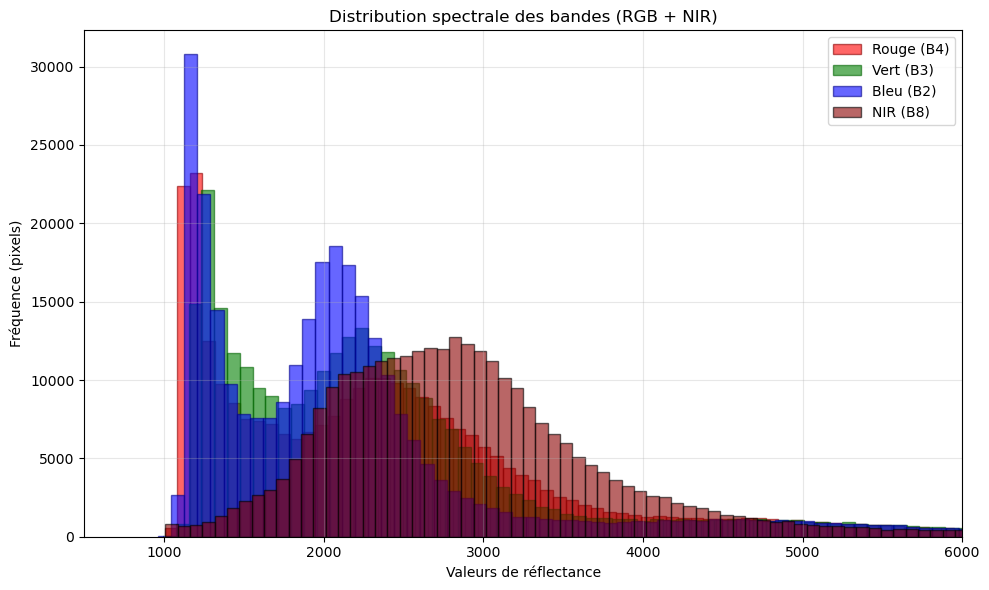

Distribution spectrale affichée


In [91]:
# Histogramme des 4 bandes (RGB + NIR)
plt.figure(figsize=(10, 6))

# Tracer les 4 distributions avec leurs couleurs respectives
plt.hist(red[~np.isnan(red)].flatten(), bins=200, alpha=0.6, color='red', label='Rouge (B4)', edgecolor='darkred')
plt.hist(green[~np.isnan(green)].flatten(), bins=200, alpha=0.6, color='green', label='Vert (B3)', edgecolor='darkgreen')
plt.hist(blue[~np.isnan(blue)].flatten(), bins=200, alpha=0.6, color='blue', label='Bleu (B2)', edgecolor='darkblue')
plt.hist(nir[~np.isnan(nir)].flatten(), bins=200, alpha=0.6, color='darkred', label='NIR (B8)', edgecolor='black')

plt.xlim(500, 6000)
plt.xlabel('Valeurs de réflectance')
plt.ylabel('Fréquence (pixels)')
plt.title('Distribution spectrale des bandes (RGB + NIR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Distribution spectrale affichée")

## Calcul et visualisation NDSI

<positron-console-cell-92>:11: RuntimeWarning: invalid value encountered in divide


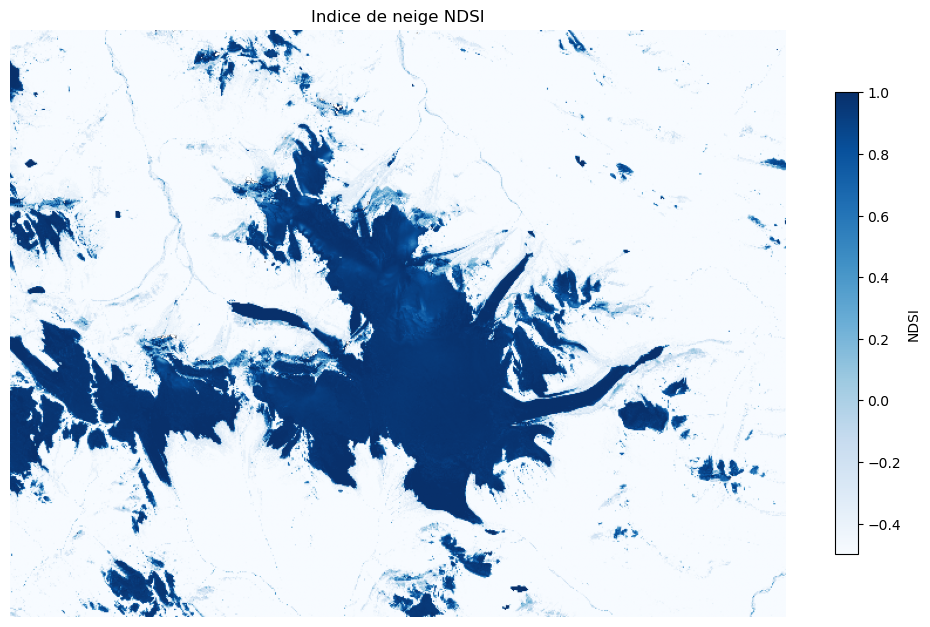

NDSI calculé - Moyenne: -0.295
Seuil de neige confirmée (NDSI > 0.4): 68989 pixels


In [ ]:
# Calculer l'indice NDSI (Normalized Difference Snow Index)
with rasterio.open(image_path) as src:
    swir = src.read(11)  # Bande 11 - SWIR (infrarouge moyen)

# Normaliser les bandes (même fonction que pour RGB)
green_norm = normalize(green)
swir_norm = normalize(swir)

# Calculer le NDSI avec formule standard (éviter division par zéro)
denom = green_norm + swir_norm
ndsi = np.where(denom > 0.0001, (green_norm - swir_norm) / denom, np.nan)

# Afficher la carte NDSI
plt.figure(figsize=(10, 8))
plt.imshow(ndsi, cmap='Blues', vmin=-0.5, vmax=1)
plt.colorbar(label='NDSI', shrink=0.6)
plt.title('Indice de neige NDSI')
plt.axis('off')
plt.tight_layout()
plt.show()

# Statistiques
print(f"NDSI calculé - Moyenne: {np.nanmean(ndsi):.3f}")